# Vaex tutorial
## Dataset
Central to vaex is the dataset (similar, but not to be confused with a pandas dataframe, hence a different name), and we often use the variables `ds` to represent it. A dataset is an efficient representation for large tabular data, and has:

 * A bunch of columns, say `x`, `y` and `z`
   * Backed by a numpy array, e.g. `ds.data.x` (but you shouldn't work with this)
   * Wrapped by an expression system, e.g. `ds.x`, `ds['x']` or `ds.col.x` is an expression
   * Columns/expression can perform lazy computations, e.g. `ds.x * np.sin(ds.y)` does nothing, until the result is needed
 * A set of virtual columns, columns that are backed by a (lazy) computation, e.g. `ds['r'] = ds.x/ds.y` 
 * A set of selection, that can be used to explore the dataset, e.g. `ds.select(ds.x < 0)`
 * A special selection (called a filter) that is always present, `ds_negative = ds[ds.x < 0]`
 
Lets start with an example dataset, included in vaex

In [1]:
import vaex
ds = vaex.example()
ds  # begin the last statement it will print out the tabular data

### Columns
The above preview shows this dataset contains $> 300,000$ rows, and columns named x,y,z (positions), vx, vy, vz (velocities), E (energy), L (angular momentum). Printing out a column, shows it is not a numpy array, but an expression

In [2]:
ds.x  # ds.col.x or ds['x'] are equivalent, but may be preferred because it is more tab completion friend or programmatics friendly respectively

<vaex.expression.Expression(expressions='x')> instance at 0x110e8bf28 [-0.777470767, 3.77427316, 1.3757627, -7.06737804, 0.243441463 ... (total 330000 values) ... 3.76883793, 9.17409325, -1.14041007, -14.2985935, 10.5450506] 

The underlying data is often accessible using `ds.data.x`, but should not be used, since selections and filtering are not reflected in this. However sometimes it is useful to access the raw numpy array.

In [6]:
ds.data.x

array([ -0.77747077,   3.77427316,   1.3757627 , ...,  -1.14041007,
       -14.2985935 ,  10.5450506 ])

A better way, if you need a numpy array (for instance for plotting, or passing to a different library) it to use evalulate, which will also work with virtual columns and selections (more on that below).

In [10]:
ds.evaluate(ds.x)

array([ -0.77747077,   3.77427316,   1.3757627 , ...,  -1.14041007,
       -14.2985935 ,  10.5450506 ])

Most numpy function (ufuncs) can be performed on expressions, and will not result in a direct result, but in a new expression.

In [5]:
import numpy as np
np.sqrt(ds.x**2 + ds.y**2 + ds.z**2)

<vaex.expression.Expression(expressions='sqrt((((x) ** (2)) + ((y) ** (2))) + ((z) ** (2)))')> instance at 0x112a86940 [2.96554503966, 5.77829281049, 6.9907960395, 9.43184275271, 0.882561312135 ... (total 330000 values) ... 7.45383176151, 15.3984124911, 8.86425027393, 17.601047186, 14.540181525] 

### Virtual functions
Sometimes it is convenient to store an expression as a column, or virtual column, a column that does not take up memory, but will be computed on the fly. A virtual column can be treated as a normal column.

In [8]:
ds['r'] = np.sqrt(ds.x**2 + ds.y**2 + ds.z**2)
ds[['x', 'y', 'z', 'r']]

### Selections and filtering
Vaex can be efficient when exploring subsets of the data, for instance to remove outlier or to inspect only a part of the data. Instead of making copies, internally vaex keeps track which rows is selected.

In [9]:
ds.select(ds.x < 0)
ds.evaluate(ds.x, selection=True)

array([ -0.77747077,  -7.06737804,  -5.17174435, ...,  -1.87310386,
        -1.14041007, -14.2985935 ])

Selections can be useful if you want to change what you select frequently, as in visualization. A special selection, that is always applied, is what we call a filtering, and is similar in use to pandas

In [12]:
ds_negative = ds[ds.x < 0]
ds_negative[['x', 'y', 'z', 'r']]

## Statistics on N-d grids
A core feature of vaex, and used for visualization, is calculation of statistics on N dimensional grids.

In [15]:
ds.count(), ds.mean(ds.x), ds.mean(ds.x, selection=True)

(330000.0, -0.067131491264005971, -5.2110379721119671)

Similar to SQL's groupby, vaex uses the binby concept, which tells vaex that a statistic should be calculated on a regular grid (for performance reasons)

In [22]:
xcounts = ds.count(binby=ds.x, limits=[-10, 10], shape=64)
xcounts

array([ 1310.,  1416.,  1452.,  1519.,  1599.,  1810.,  1956.,  2005.,
        2157.,  2357.,  2653.,  2786.,  3012.,  3215.,  3619.,  3890.,
        3973.,  4400.,  4782.,  5126.,  5302.,  5729.,  6042.,  6562.,
        6852.,  7167.,  7456.,  7633.,  7910.,  8415.,  8619.,  8246.,
        8358.,  8769.,  8294.,  7870.,  7749.,  7389.,  7174.,  6901.,
        6557.,  6173.,  5721.,  5367.,  4963.,  4655.,  4246.,  4110.,
        3939.,  3611.,  3289.,  3018.,  2811.,  2570.,  2505.,  2267.,
        2013.,  1803.,  1687.,  1563.,  1384.,  1326.,  1257.,  1189.])

This results in a numpy array with the number counts in 64 bins distributed between x = -10, and x = 10. We can quickly visualize this using matplotlib.

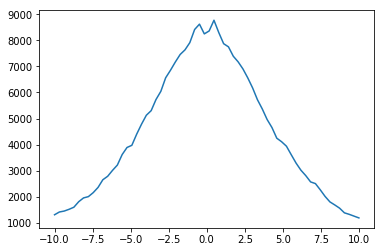

In [25]:
import matplotlib.pylab as plt
plt.plot(np.linspace(-10, 10, 64), xcounts)
plt.show()

We can instead of doing 1d binning, do it in 2d as well (N-d actually), and visualize it using imshow.

In [27]:
xycounts = ds.count(binby=[ds.x, ds.y], limits=[[-10, 10], [-10, 20]], shape=(64, 128))
xycounts

array([[  9.,   3.,   3., ...,   3.,   2.,   1.],
       [  5.,   3.,   1., ...,   1.,   3.,   3.],
       [ 11.,   3.,   2., ...,   1.,   1.,   4.],
       ..., 
       [ 12.,   6.,   8., ...,   0.,   1.,   0.],
       [  7.,   6.,  12., ...,   3.,   0.,   0.],
       [ 11.,  10.,   7., ...,   1.,   1.,   1.]])

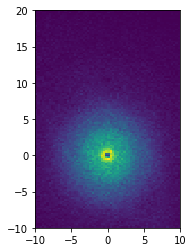

In [33]:
plt.imshow(xycounts.T, origin='lower', extent=[-10, 10, -10, 20])
plt.show()

In [34]:
v = np.sqrt(ds.vx**2 + ds.vy**2 + ds.vz**2)
xy_mean_v = ds.mean(v, binby=[ds.x, ds.y], limits=[[-10, 10], [-10, 20]], shape=(64, 128))
xy_mean_v

array([[ 144.38495511,  183.45775869,  187.78325557, ...,  138.99392387,
         168.66141282,  142.55018784],
       [ 143.72427758,  152.14679337,  107.90949865, ...,  119.65318885,
          94.00098292,  104.35109636],
       [ 172.08240652,  137.47896886,   72.51331138, ...,  179.85933835,
          33.36968912,  111.81826254],
       ..., 
       [ 186.56949934,  161.3747346 ,  174.27411865, ...,           nan,
         105.96746091,           nan],
       [ 179.55997022,  137.48979882,  113.82121826, ...,  104.90205692,
                  nan,           nan],
       [ 151.94323763,  135.44083212,   84.81787495, ...,  175.79289144,
         129.63799565,  108.19069385]])

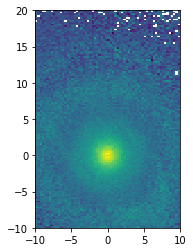

In [35]:
plt.imshow(xy_mean_v.T, origin='lower', extent=[-10, 10, -10, 20])
plt.show()